In [33]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet as wn
from collections import defaultdict
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import accuracy_score

# 文本处理

In [3]:
data = pd.read_excel(
    r"E:/Pythonworkspace/patent/process_data/sample3_G-06-F-17/textual/patent_text_2010.xlsx", encoding='utf-8')

In [4]:
data.head(3)

,application_id,title,abstract,claims,result
0,11041610,METHOD OF PRINTING SECURITY DOCUMENTS,A method of providing a security document havi...,1. A method of providing a security document ...,1
1,11619583,Method for Identifying Phone Numbers and Alpha...,A method and system provides the ability to id...,"1. A method comprising:, receiving a text sou...",0
2,12165740,Translating Search Strings into Physical Locat...,This description provides tools and techniques...,1. A computer-readable storage medium having ...,1


In [5]:
len(data)

7769

## 分句

In [28]:
abstract_max_len = []
for index, abstract in enumerate(tqdm(data['abstract'], ncols=70)):
    tokens = sent_tokenize(abstract)
    token_list = []
    for token in tokens:
        if len(token) < 3:
            pass
        else:
            token_list.append(token)
    abstract_max_len.append(len(token_list))
    data.loc[index, 'abstract_sen_count'] = len(token_list)

100%|███████████████████████████| 7769/7769 [00:04<00:00, 1676.05it/s]


In [30]:
claims_max_len = []
for index, claims in enumerate(tqdm(data['claims'], ncols=70)):
    tokens = sent_tokenize(claims)
    token_list = []
    for token in tokens:
        if len(token) < 3:
            pass
        else:
            token_list.append(token)
    claims_max_len.append(len(token_list))
    data.loc[index, 'claims_sen_count'] = len(token_list)

100%|████████████████████████████| 7769/7769 [00:18<00:00, 425.35it/s]


## 分词

### abstract

In [6]:
data['abstract'].dropna(inplace=True)
# data['abstract'] = [entry.lower() for entry in data['abstract']]
data['abstract'] = [word_tokenize(entry) for entry in data['abstract']]

In [7]:
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

len_abstract = []
for index, entry in enumerate(tqdm(data['abstract'], ncols=70)):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])  # 对这三类做词形还原
            Final_words.append(word_Final)
    len_abstract.append(len(Final_words))
    data.loc[index, 'abstract_final'] = str(Final_words)
    data.loc[index, 'abstract_count'] = len(Final_words)

100%|█████████████████████████████| 7769/7769 [19:57<00:00,  6.49it/s]


### claims

In [8]:
data['claims'].dropna(inplace=True)
# data['claims'] = [entry.lower() for entry in data['claims']]
data['claims'] = [word_tokenize(entry) for entry in data['claims']]

In [9]:
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

len_claims = []
for index, entry in enumerate(tqdm(data['claims'], ncols=70)):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])  # 对这三类做词形还原
            Final_words.append(word_Final)
    len_claims.append(len(Final_words))
    data.loc[index, 'claims_final'] = str(Final_words)
    data.loc[index, 'claims_count'] = len(Final_words)

100%|█████████████████| 7769/7769 [1:38:46<00:00,  1.31it/s]


## 文本长度分布

In [15]:
def status(x):
    return pd.Series([x.count(), x.sum(), x.min(), x.idxmin(), x.quantile(.25), x.median(),
                      x.quantile(.75), x.quantile(.90), x.quantile(.95), x.quantile(.99), x.mean(), 
                      x.max(), x.idxmax(), x.mode(), x.mad(), x.var(), x.std(), x.skew(), x.kurt()], 
                     index=['非空数', '求和', '最小值', '最小值位置', '25%分位数', '中位数', '75%分位数', 
                            '90%分位数', '95%分位数', '99%分位数', '均值', '最大值', '最大值位数', '众数', 
                            '平均绝对偏差', '方差', '标准差', '偏度', '峰度'])

In [32]:
df = pd.DataFrame(np.array([len_abstract, len_claims, abstract_max_len, claims_max_len, data['result']]).T, columns=[
                  'len_abstract', 'len_claims', 'abstract_max_len', 'claims_max_len', 'result'])
df.apply(status)

,len_abstract,len_claims,abstract_max_len,claims_max_len,result
非空数,7769,7769,7769,7769,7769
求和,541263,5240778,30447,253443,5168
最小值,5,18,1,1,0
最小值位置,327,1091,3,4,1
25%分位数,52,435,2,22,0
中位数,70,596,4,32,1
75%分位数,86,819,5,37,1
90%分位数,97,1120,7,52,1
95%分位数,107,1389.8,8,68,1
99%分位数,137.32,2252.32,10,111,1


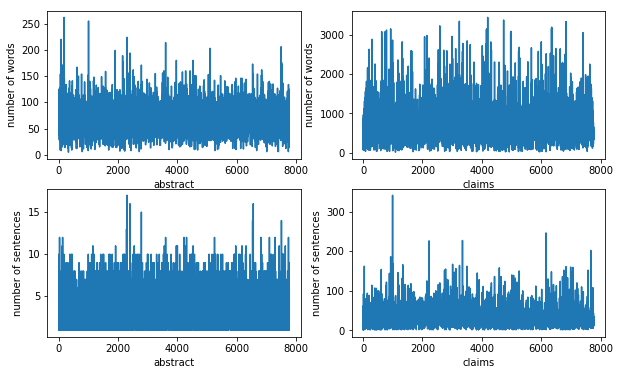

In [35]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(221)
plt.plot(df['len_abstract'].index, df['len_abstract'].values)
plt.ylabel("number of words")
plt.xlabel("abstract")

plt.subplot(222)
plt.plot(df['len_claims'].index, df['len_claims'].values)
plt.ylabel("number of words")
plt.xlabel("claims")

plt.subplot(223)
plt.plot(df['abstract_max_len'].index, df['abstract_max_len'].values)
plt.ylabel("number of sentences")
plt.xlabel("abstract")

plt.subplot(224)
plt.plot(df['claims_max_len'].index, df['claims_max_len'].values)
plt.ylabel("number of sentences")
plt.xlabel("claims")

plt.show()

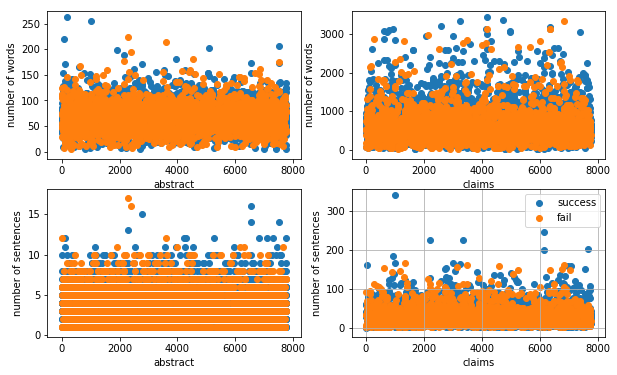

In [37]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(221)
df1 = df[df['result'] == 1]
plt.scatter(df1.index, df1['len_abstract'], label="success")
df2 = df[df['result'] == 0]
plt.scatter(df2.index, df2['len_abstract'], label="fail")
plt.ylabel("number of words")
plt.xlabel("abstract")

plt.subplot(222)
df1 = df[df['result'] == 1]
plt.scatter(df1.index, df1['len_claims'], label="success")
df2 = df[df['result'] == 0]
plt.scatter(df2.index, df2['len_claims'], label="fail")
plt.ylabel("number of words")
plt.xlabel("claims")

plt.subplot(223)
df1 = df[df['result'] == 1]
plt.scatter(df1.index, df1['abstract_max_len'], label="success")
df2 = df[df['result'] == 0]
plt.scatter(df2.index, df2['abstract_max_len'], label="fail")
plt.ylabel("number of sentences")
plt.xlabel("abstract")

plt.subplot(224)
df1 = df[df['result'] == 1]
plt.scatter(df1.index, df1['claims_max_len'], label="success")
df2 = df[df['result'] == 0]
plt.scatter(df2.index, df2['claims_max_len'], label="fail")
plt.ylabel("number of sentences")
plt.xlabel("claims")

plt.legend()
plt.grid()
plt.show()

In [ ]:
data.to_excel(
    "E:/Pythonworkspace/patent/process_data/sample3_G-06-F-17/textual/after_process.xlsx", encoding='utf-8')

# TF-IDF

In [43]:
data.head(2)

,application_id,title,abstract,claims,result,abstract_final,claims_final,claims_count,abstract_count,abstract__sen_count,claims_sen_count
0,11041610,METHOD OF PRINTING SECURITY DOCUMENTS,"[A, method, of, providing, a, security, docume...","[1, ., A, method, of, providing, a, security, ...",1,"['A', 'method', 'provide', 'security', 'docume...","['A', 'method', 'provide', 'security', 'docume...",622.0,46.0,4.0,29.0
1,11619583,Method for Identifying Phone Numbers and Alpha...,"[A, method, and, system, provides, the, abilit...","[1, ., A, method, comprising, :, ,, receiving,...",0,"['A', 'method', 'system', 'provide', 'ability'...","['A', 'method', 'comprising', 'receive', 'text...",397.0,125.0,6.0,32.0


## abstract

In [103]:
Tfidf_vect_abs = TfidfVectorizer(max_features=300)
Tfidf_vect_abs.fit(data['abstract_final'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=300,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [104]:
Tfidf_feature_abs = Tfidf_vect_abs.transform(data['abstract_final'])
Tfidf_feature_abs

<7769x300 sparse matrix of type '<class 'numpy.float64'>'
	with 164711 stored elements in Compressed Sparse Row format>

In [105]:
df_abs = pd.DataFrame(Tfidf_feature_abs.toarray())
df_abs.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.154238,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.25314,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.095408,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
df_abs.shape

(7769, 300)

In [107]:
# 保存
df_abs.to_excel(
    "E:/Pythonworkspace/patent/process_data/sample3_G-06-F-17/textual/abstract_TF-IDF_300d.xlsx")

## claims

In [93]:
Tfidf_vect_claims = TfidfVectorizer(max_features=300)
Tfidf_vect_claims.fit(data['claims_final'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=300,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [94]:
Tfidf_feature_claims = Tfidf_vect_claims.transform(data['claims_final'])
Tfidf_feature_claims

<7769x300 sparse matrix of type '<class 'numpy.float64'>'
	with 393060 stored elements in Compressed Sparse Row format>

In [95]:
df_claims = pd.DataFrame(Tfidf_feature_claims.toarray())
df_claims.head(3)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.0,0.231446,0.047851,0.0,0.0,0.0,0.0,0.0,0.000000,0.022486,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.153832,0.000000,0.016252,0.0
1,0.0,0.273842,0.056617,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.082028,0.0,0.078004,0.164664,0.000000,0.0
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.101415,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.100685,0.028130,0.026281,0.0


In [96]:
df_claims.shape

(7769, 300)

In [97]:
# 保存
df_claims.to_excel(
    "E:/Pythonworkspace/patent/process_data/sample3_G-06-F-17/textual/claims_TF-IDF_300d.xlsx")